# 1. Import libraries

In [1]:
# Import necessary libraries
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from google.colab import drive
import numpy as np

# From here, add any libraries that you might need for the rest of your code
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate, BatchNormalization, Lambda, Resizing, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from keras.models import Model
import numpy as np
print(keras.__version__)
print(tf.__version__)

3.5.0
2.17.0


# 2. Load and pre-process the dataset

In [2]:
import os

# Set the paths based on your Drive directory
data_dir = r'D:\Documents\Master_Data_Science\Deep Learning\group_assignment\brain_mri_dataset'
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')

# Print the directory paths
print(f"Data directory: {data_dir}")
print(f"Training images directory: {train_images_dir}")
print(f"Testing images directory: {test_images_dir}")


Data directory: D:\Documents\Master_Data_Science\Deep Learning\group_assignment\brain_mri_dataset
Training images directory: D:\Documents\Master_Data_Science\Deep Learning\group_assignment\brain_mri_dataset\Training
Testing images directory: D:\Documents\Master_Data_Science\Deep Learning\group_assignment\brain_mri_dataset\Testing


In [3]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# Load and preprocess the data
np.random.seed(seed=42)
def add_noise(img):
    std_coeff = 70*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

image_res = 30
def get_images(train_dir: str, test_dir: str):
    datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

    img_height, img_width = image_res, image_res
    batch_size = 32

    # Load training data
    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        color_mode='grayscale'
    )

    # Load test data
    test_data = datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        color_mode='grayscale'
    )

    return train_data, test_data

# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


## 2.1 Splitting off validation set

In [4]:
# splitting validation set from train_data
# extract images and labels from train_data
class_indices = train_data.class_indices
images = []
labels = []

for i in range(len(train_data)):
    img, lbl = train_data[i]
    images.append(img)
    labels.append(lbl)

# concatenate lists to numpy arrays
images = np.concatenate(images, axis=0)
labels = np.concatenate(labels, axis=0)

# split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.25, random_state=42)

# create ImageDataGenerator instances
datagen = ImageDataGenerator()

# create new iterators for training and validation sets
train_data = datagen.flow(train_images, train_labels, batch_size=32, shuffle=True)
val_data = datagen.flow(val_images, val_labels, batch_size=32, shuffle=False)

# store class_indices and labels in the new iterators
train_data.class_indices = class_indices
train_data.labels = train_labels

val_data.class_indices = class_indices
val_data.labels = val_labels

# sanity check for train_data
for images, labels in train_data:
    print(f"Processed image shape: {images.shape}")
    print(f"Label shape: {labels.shape}") # labels are already one-hot encoded
    break

# sanity check for val_data
for images, labels in val_data:
    print(f"Processed image shape: {images.shape}")
    print(f"Label shape: {labels.shape}") # labels are already one-hot encoded
    break 

Processed image shape: (32, 30, 30, 1)
Label shape: (32, 4)
Processed image shape: (32, 30, 30, 1)
Label shape: (32, 4)


In [5]:
print(f'Number of training samples: {train_data.n}')
print(f'Number of validation samples: {val_data.n}')
print(f'Number of test samples: {test_data.n}')

Number of training samples: 4284
Number of validation samples: 1428
Number of test samples: 1311


# 3. Visualise data and plot data distribution

inspect the data that we are working with

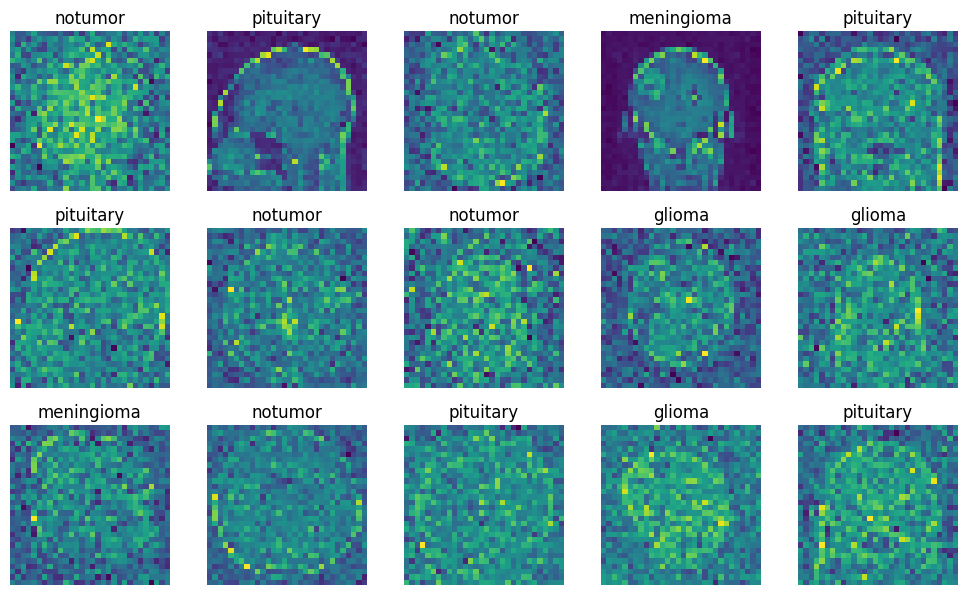

In [6]:
def plot_sample_images(data, num_images=15):
    """
    Plot sample images from the data.
    Args:
        data: DirectoryIterator object.
        num_images: # of images to display.
    """
    classes = list(data.class_indices.keys())
    images, labels = next(data)

    # sample 15 random indices
    sample_indices = np.random.choice(images.shape[0], num_images, replace=False)

    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(sample_indices):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[idx])
        plt.title(classes[np.argmax(labels[idx])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# plot some sample images
plot_sample_images(train_data)


check for class imbalance

C:\Users\tuur\AppData\Local\Temp\ipykernel_23356\3969683922.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', len(classes))


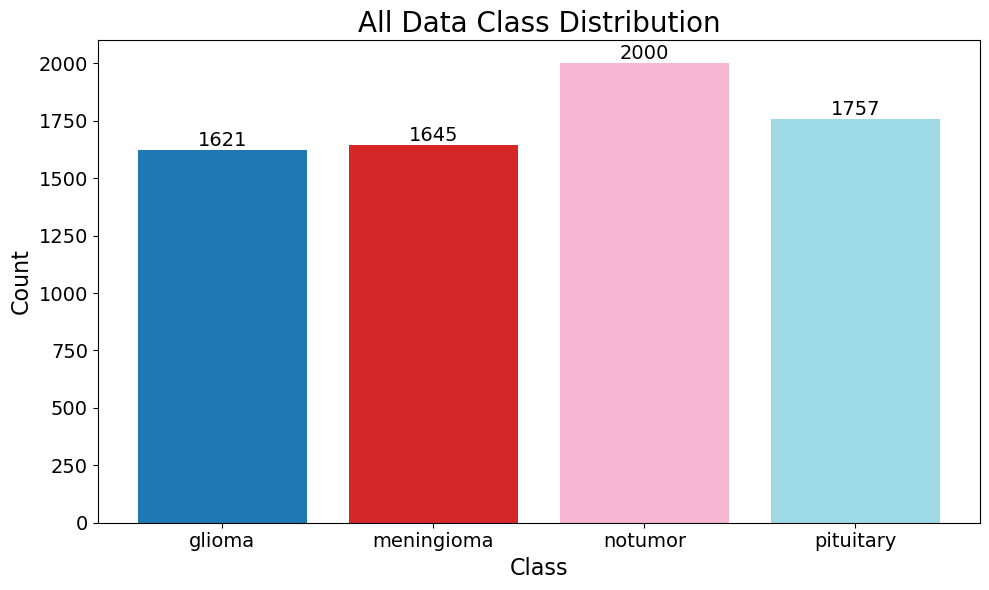

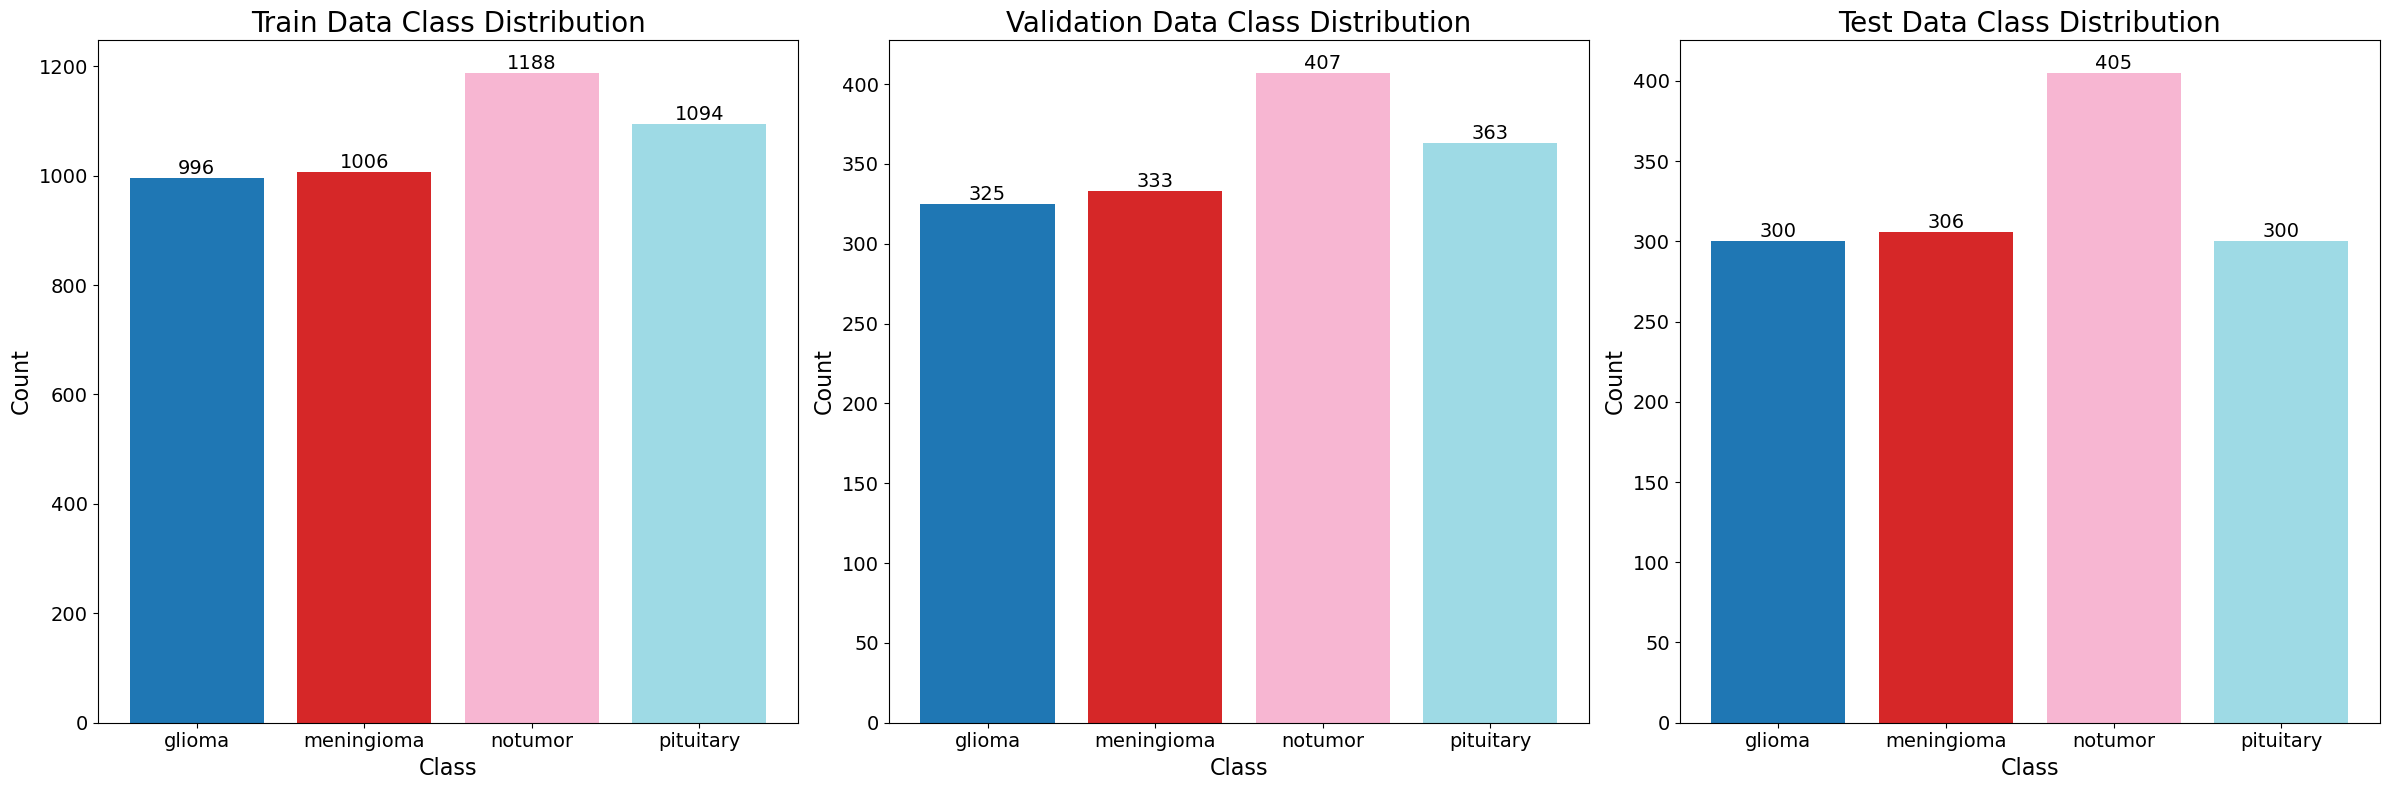

In [6]:
def plot_class_distribution(train_data, val_data, test_data):
    """
    Plot class distribution of the train data, validation data, and test data in three sub-barplots.
    As well as the class distribution for all data splits combined.
    Args:
        train_data: DirectoryIterator object for training data.
        val_data: DirectoryIterator object for validation data.
        test_data: DirectoryIterator object for test data.
    """
    classes = list(train_data.class_indices.keys())
    colors = cm.get_cmap('tab20', len(classes))

    datasets = [
        (train_data, 'Train Data Class Distribution'),
        (val_data, 'Validation Data Class Distribution'),
        (test_data, 'Test Data Class Distribution')
    ]

    train_labels = np.argmax(train_data.labels, axis=1) if train_data.labels.ndim > 1 else train_data.labels
    val_labels = np.argmax(val_data.labels, axis=1) if val_data.labels.ndim > 1 else val_data.labels
    test_labels = np.argmax(test_data.labels, axis=1) if test_data.labels.ndim > 1 else test_data.labels

    # Plot combined class distribution
    plt.figure(figsize=(10, 6))
    combined_labels = np.concatenate([train_labels, val_labels, test_labels], axis=0)
    combined_class_counts = np.bincount(combined_labels)
    ax_combined = plt.subplot(1, 1, 1)
    bars_combined = ax_combined.bar(classes, combined_class_counts, color=[colors(j) for j in range(len(classes))])
    ax_combined.set_title('All Data Class Distribution', fontsize=20)
    ax_combined.set_xlabel('Class', fontsize=16)
    ax_combined.set_ylabel('Count', fontsize=16)
    ax_combined.set_xticks(range(len(classes)))
    ax_combined.set_xticklabels(classes, fontsize=14)
    ax_combined.tick_params(axis='y', labelsize=14)
    ax_combined.bar_label(bars_combined, fontsize=14)
    plt.tight_layout()
    plt.show()

    # Plot individual class distributions
    plt.figure(figsize=(24, 8))
    for i, (data, title) in enumerate(datasets, 1):
        labels = np.argmax(data.labels, axis=1) if data.labels.ndim > 1 else data.labels
        class_counts = np.bincount(labels)
        ax = plt.subplot(1, 3, i)
        bars = ax.bar(classes, class_counts, color=[colors(j) for j in range(len(classes))])
        ax.set_title(title, fontsize=20)
        ax.set_xlabel('Class', fontsize=16)
        ax.set_ylabel('Count', fontsize=16)
        ax.set_xticks(range(len(classes)))
        ax.set_xticklabels(classes, fontsize=14)
        ax.tick_params(axis='y', labelsize=14)
        ax.bar_label(bars, fontsize=14)

    plt.tight_layout()
    plt.show()



plot_class_distribution(train_data, val_data, test_data)

# 4. Train and Evaluation functions

In [8]:
def plot_training_curves(history):
    """
    Plot training and validation loss and accuracy curves.
    Args:
        history: history object from model.fit.
    """
    plt.figure(figsize=(12, 6))

    # plot training and validation loss
    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # plot training and validation accuracy
    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
def plot_roc_curve(y_pred, data):
    """
    Plot ROC curve for the model predictions.
    Args:
        y_pred: model predictions as probabilities.
        data: data containing the true labels.
    """
    y_true = data.labels # obtain the true labels from the data
    if len(y_true.shape) == 1: # if the labels are not onehot encoded
        y_true = to_categorical(y_true, num_classes=np.unique(y_true).size) # onehot encode the labels

    # retrieve class names
    classes = list(data.class_indices.keys())

    n_classes = y_true.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    colors = cm.get_cmap('tab20', n_classes)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [10]:
def get_evaluation_metrics(y_pred, data):
    """
    Get evaluation metrics for the model predictions.
    Args:
        y_pred: model predictions as probabilities.
        data: data containing the true labels.
    Returns:
        A dictionary containing the evaluation metrics.
    """
    # convert predicted probabilities to predicted class labels
    y_pred = np.argmax(y_pred, axis=1)

    y_true = data.labels # obtain the true labels from the data
    # ensure y_true is not onehot encoded
    if len(y_true.shape) > 1:
        y_true = np.argmax(y_true, axis=1)

    # retrieve class names
    classes = list(data.class_indices.keys())

    # f1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    # classification report
    print(f'f1 score: {f1}')
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=classes))

    return


In [11]:
def plot_confusion_matrix(y_pred, data):
    """
    Plot confusion matrix for the model predictions.
    Args:
        y_pred: model predictions as probabilities.
        data: data containing the true labels.
    """
    y_true = data.labels
    # ensure y_true is in integer format
    if len(y_true.shape) > 1:
        y_true = np.argmax(y_true, axis=1)

    # retrieve class names
    classes = list(data.class_indices.keys())

    # get the predictions from the probabilities
    y_pred = np.argmax(y_pred, axis=1)

    # compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # plot the confusion matrix
    ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap='Blues', values_format='d', colorbar=True)

# 5. Model training

train baseline model

In [13]:
# define the model
def create_baseline():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape = images.shape[1:]))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    return model
baseline = create_baseline()
baseline.summary()

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,596 (182.02 KB)

 Trainable params: 46,596 (182.02 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# train the baseline model
baseline.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = baseline.fit(train_data, epochs=10, validation_data=val_data, verbose=1) # the dataset/loader defined by the teachers already encodes the batch size (see preprocessing code)

Epoch 1/10
 21/134 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2908 - loss: 1.3685

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3998 - loss: 1.2322 - val_accuracy: 0.6912 - val_loss: 0.8373
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7108 - loss: 0.7906 - val_accuracy: 0.7360 - val_loss: 0.6901
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7519 - loss: 0.6585 - val_accuracy: 0.7633 - val_loss: 0.6257
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7727 - loss: 0.6058 - val_accuracy: 0.7850 - val_loss: 0.6059
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8051 - loss: 0.5261 - val_accuracy: 0.7759 - val_loss: 0.5903
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8227 - loss: 0.4683 - val_accuracy: 0.7871 - val_loss: 0.5509
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8219 - loss: 0.4648 - val_accuracy: 0.7920 - val_loss: 0.5407
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8453 - loss: 0.4291 - val_accuracy: 0.8060 - val

# 6. Model evaluation

evaluate baseline model

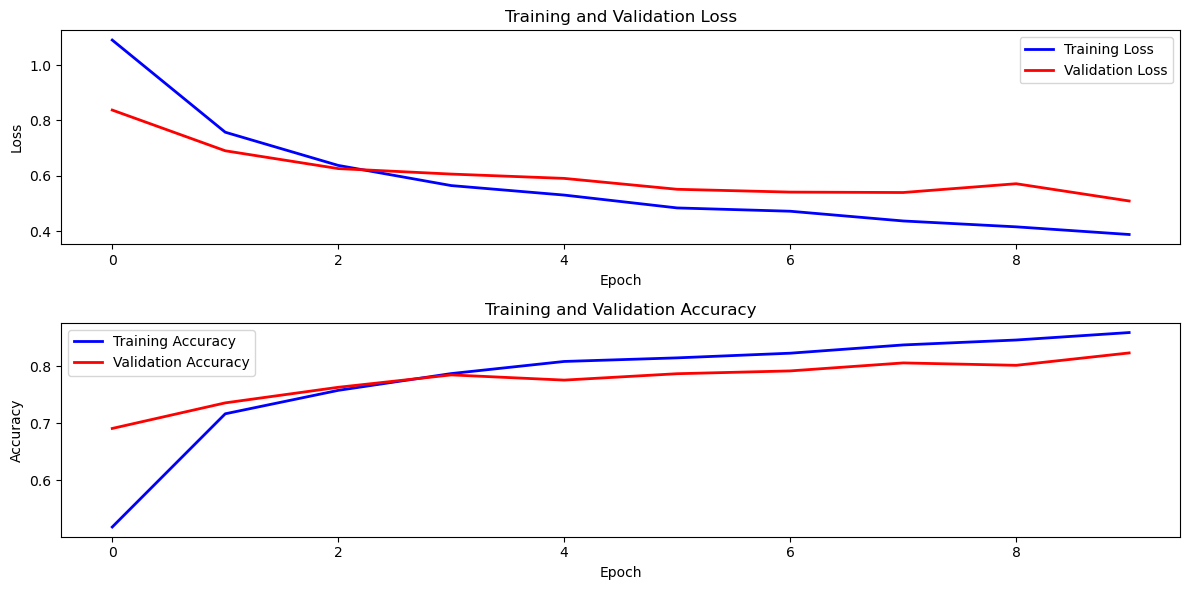

In [15]:
# plot the training curves
plot_training_curves(history)

In [16]:
# obtain prediction on validation data
val_y_pred = baseline.predict(val_data)
# obtain predictions on test data
test_y_pred = baseline.predict(test_data)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_6224\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


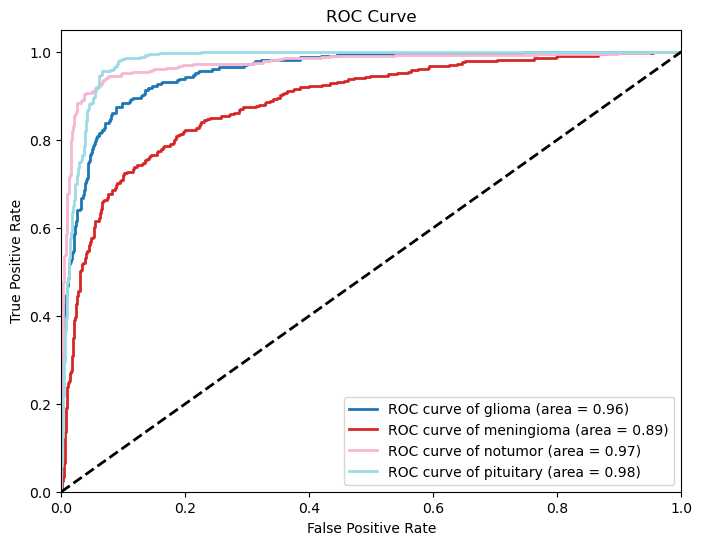

In [18]:
# plot the roc curve of the validation data
plot_roc_curve(val_y_pred, val_data)

C:\Users\tuur\AppData\Local\Temp\ipykernel_6224\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


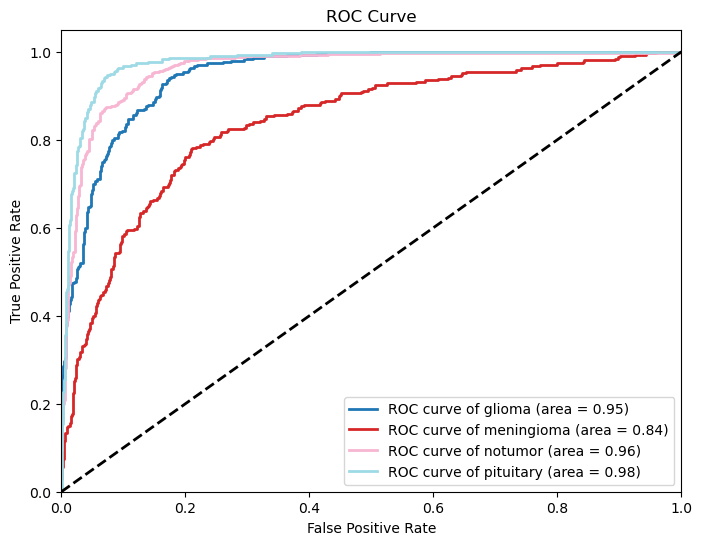

In [19]:
# plot the roc curve of the test data
plot_roc_curve(test_y_pred, test_data)

In [20]:
# get evaluation metric of validation data
get_evaluation_metrics(val_y_pred, val_data)

f1 score: 0.8187519679400578
Classification Report:
              precision    recall  f1-score   support

      glioma       0.80      0.81      0.80       325
  meningioma       0.76      0.60      0.67       333
     notumor       0.90      0.90      0.90       407
   pituitary       0.81      0.96      0.88       363

    accuracy                           0.82      1428
   macro avg       0.82      0.82      0.81      1428
weighted avg       0.82      0.82      0.82      1428



In [21]:
# get evaluation metric of test data
get_evaluation_metrics(test_y_pred, test_data)

f1 score: 0.7571778926223356
Classification Report:
              precision    recall  f1-score   support

      glioma       0.76      0.74      0.75       300
  meningioma       0.66      0.47      0.55       306
     notumor       0.82      0.87      0.85       405
   pituitary       0.77      0.95      0.85       300

    accuracy                           0.77      1311
   macro avg       0.75      0.76      0.75      1311
weighted avg       0.76      0.77      0.76      1311



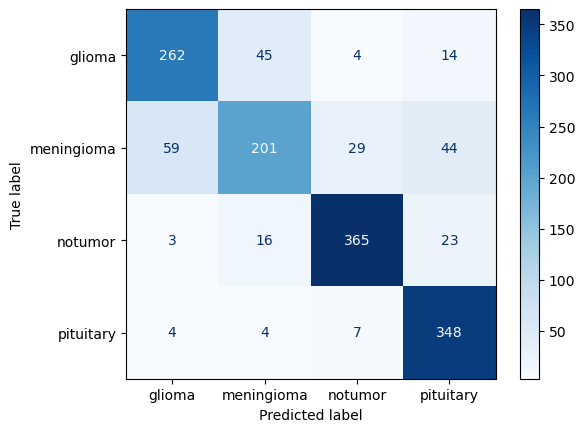

In [22]:
# plot confusion matrix of validation data
plot_confusion_matrix(val_y_pred, val_data)

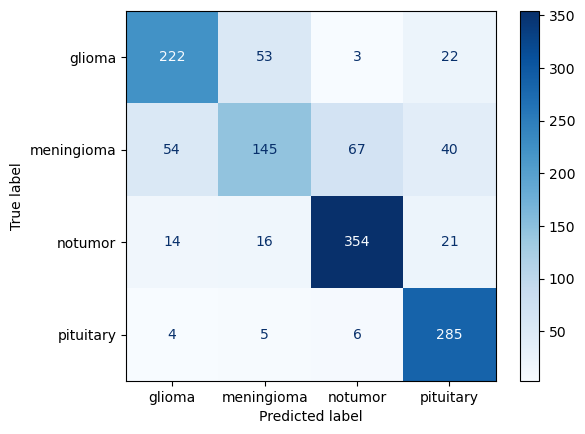

In [23]:
# plot confusion matrix of test data
plot_confusion_matrix(test_y_pred, test_data)

# 7. Enhanced model

## 7.1 Enhanced model architecure

try to improve on baseline model

In [32]:
def enhanced_model():   
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape= images.shape[1:], padding = "same" ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding = "same" ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu',padding = "same" ))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Flattening and Dense layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='softmax'))   

    return model


# Instantiate the model
model = enhanced_model()

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss='categorical_crossentropy')
model.summary()

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               restore_best_weights=True)

# Train the model with increased epochs and early stopping
enhanced_history = model.fit(train_data, epochs=30,  # Increased number of epochs
                    batch_size=32,
                    validation_data=val_data,
                    callbacks=[early_stopping],  # Adding early stopping
                    verbose=1)


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 249,668 (975.27 KB)

 Trainable params: 249,220 (973.52 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.5747 - loss: 1.0784 - val_accuracy: 0.2542 - val_loss: 1.6221
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7863 - loss: 0.5490 - val_accuracy: 0.2836 - val_loss: 3.7073
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8640 - loss: 0.3766 - val_accuracy: 0.5196 - val_loss: 1.7015
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8890 - loss: 0.2728 - val_accuracy: 0.6800 - val_loss: 1.1373
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9309 - loss: 0.1862 - val_accuracy: 0.7178 - val_loss: 1.0086
Epoch 6/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9531 - loss: 0.1338 - val_accuracy: 0.7801 - val_loss: 0.7554
Epoch 7/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9525 - loss: 0.1355 - val_accuracy: 0.7115 - val_loss: 1.0099
Epoch 8/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9657 - loss: 0.0965 - val_accu

## 7.2 Enhanced model evaluation

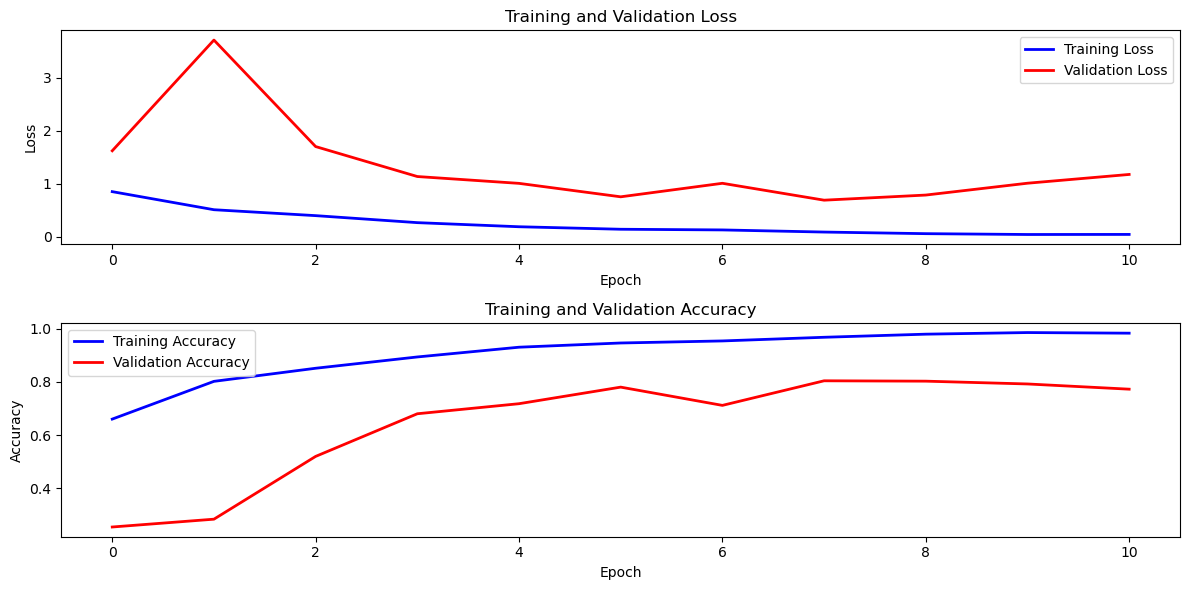

In [33]:
# plot the training curves
plot_training_curves(enhanced_history)

In [34]:
# obtain prediction on validation data
val_y_pred = model.predict(val_data)
# obtain predictions on test data
test_y_pred = model.predict(test_data)

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


C:\Users\tuur\AppData\Local\Temp\ipykernel_7052\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


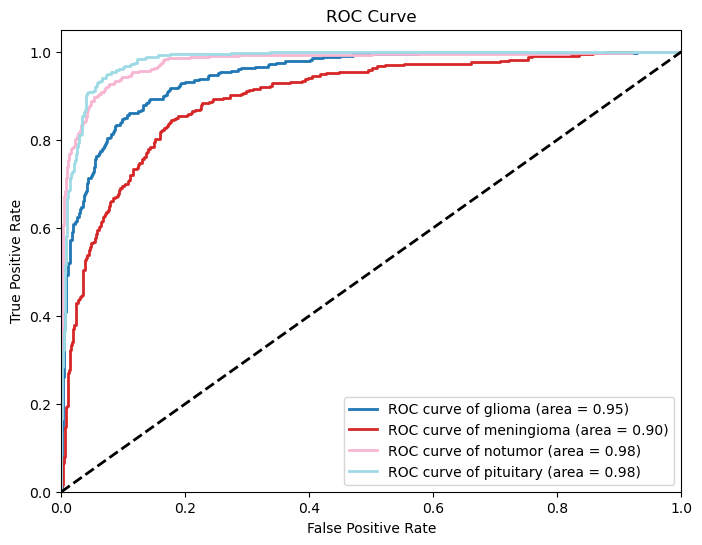

In [35]:
# plot the roc curve of the validation data
plot_roc_curve(val_y_pred, val_data)

C:\Users\tuur\AppData\Local\Temp\ipykernel_7052\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', n_classes)


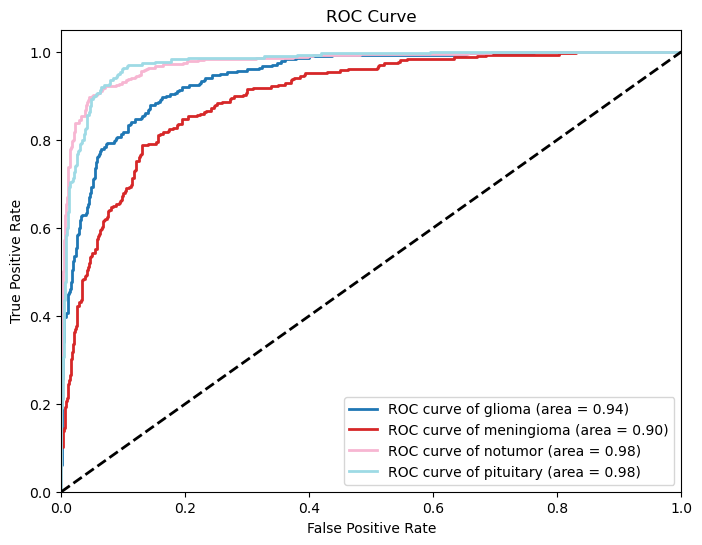

In [36]:
# plot the roc curve of the test data
plot_roc_curve(test_y_pred, test_data)

In [37]:
# get evaluation metric of validation data
get_evaluation_metrics(val_y_pred, val_data)

f1 score: 0.8036603212850141
Classification Report:
              precision    recall  f1-score   support

      glioma       0.84      0.65      0.73       325
  meningioma       0.64      0.74      0.69       333
     notumor       0.87      0.88      0.88       407
   pituitary       0.87      0.91      0.89       363

    accuracy                           0.80      1428
   macro avg       0.81      0.80      0.80      1428
weighted avg       0.81      0.80      0.80      1428



In [38]:
# get evaluation metric of test data
get_evaluation_metrics(test_y_pred, test_data)

f1 score: 0.8030871404881404
Classification Report:
              precision    recall  f1-score   support

      glioma       0.86      0.61      0.72       300
  meningioma       0.64      0.78      0.71       306
     notumor       0.89      0.89      0.89       405
   pituitary       0.84      0.90      0.87       300

    accuracy                           0.80      1311
   macro avg       0.81      0.80      0.80      1311
weighted avg       0.82      0.80      0.80      1311



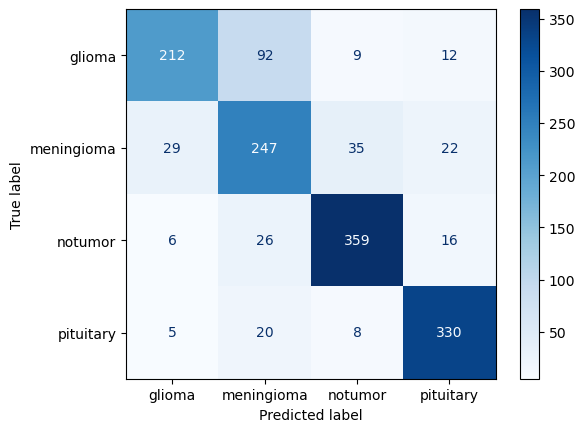

In [39]:
# plot confusion matrix of validation data
plot_confusion_matrix(val_y_pred, val_data)

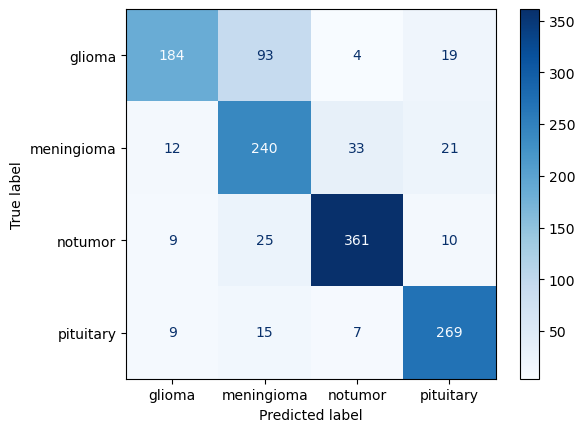

In [40]:
# plot confusion matrix of test data
plot_confusion_matrix(test_y_pred, test_data)

# 8. Transfer learning

Pretrained models (e.g. ResNet50) does not take grayscale 30x30 images as input. All images are therefore rescaled to a higher resolution (90x90) and the grayscale channel is converted to three RGB channels, resulting in a (90x90x3) input size, instead of the original (30x30x1). Also possible to rescale images to even higher resolution, however, we are experiencing computational restraints.

## 8.1 Plotting the effect of resizing images to check quality

1/1 [==============================] - 0s 59ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17817366..0.9605009].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00016647534..0.8626641].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.53007317..1.0397877].


Grayscale image shape: (32, 30, 30, 1)
RGB image shape: (32, 90, 90, 3)


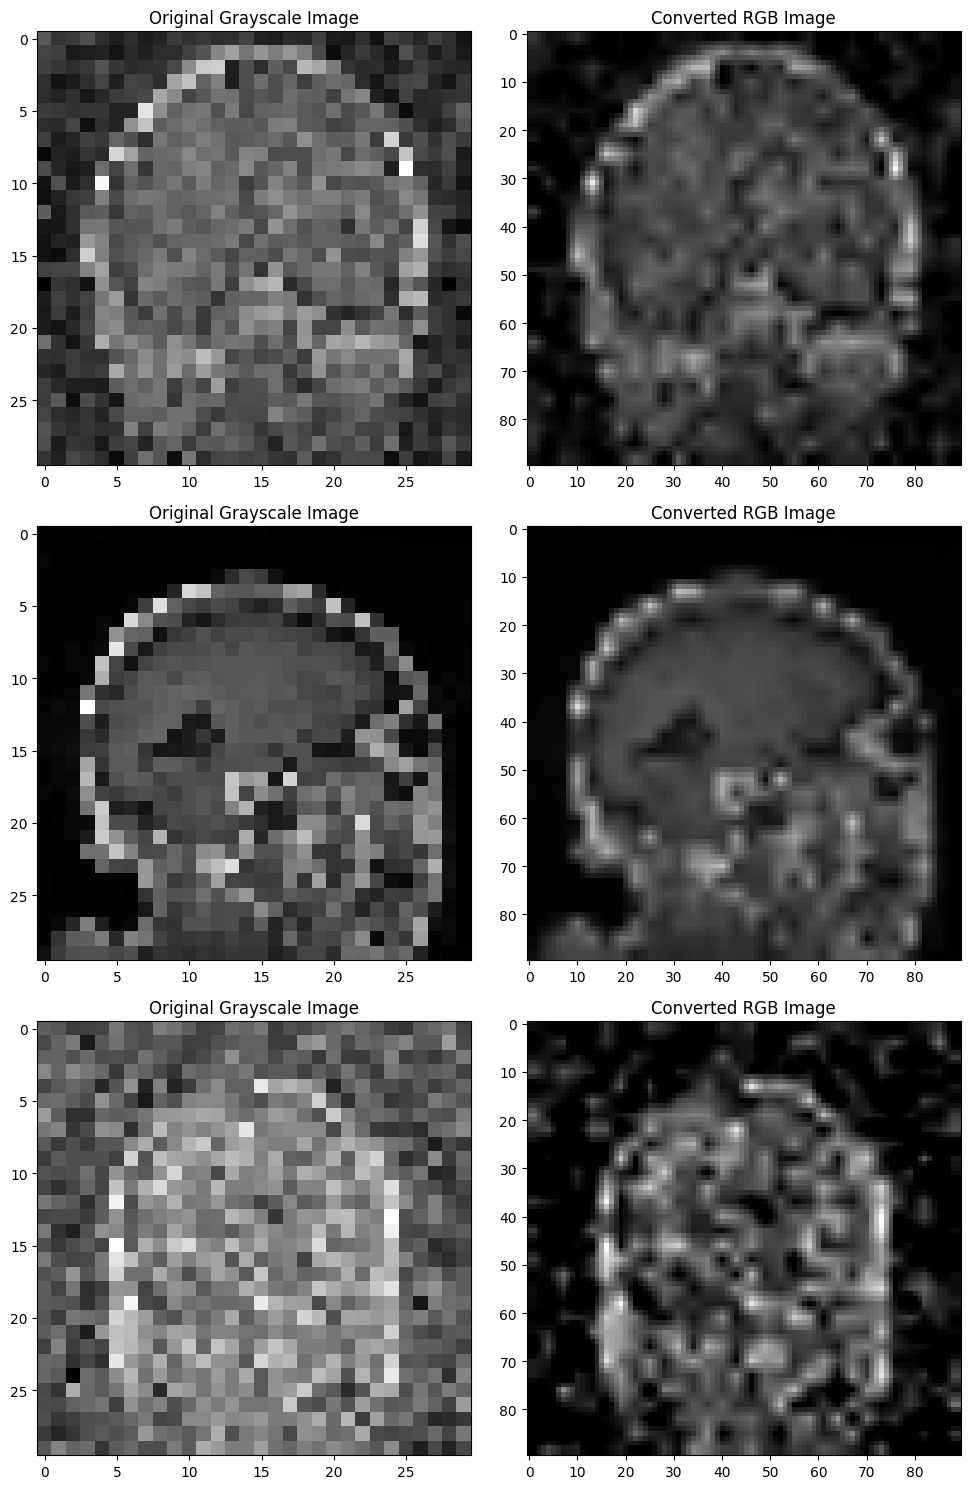

In [12]:
# plot the effect of resizing the images for the transfer learning model to check data quality
image_size = 30  # the current image size

# input layer for grayscale images (1 channel)
input_tensor = Input(shape=(image_size, image_size, 1))

x = Resizing(90, 90)(input_tensor) # resolutional to resize to (90x90)

# duplicate the single channel to convert grayscale to 3 channels (RGB)
x = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(x)


model = Model(inputs=input_tensor, outputs=x)

# extract a batch of images from train_data
grayscale_images, _ = next(train_data)
grayscale_images = grayscale_images

# use the model to convert grayscale images to RGB
rgb_images = model.predict(grayscale_images)
print(f"Grayscale image shape: {grayscale_images.shape}")
print(f"RGB image shape: {rgb_images.shape}")

# number of images to plot
num_images = 3

# randomly select num_images indices from the batch
random_indices = np.random.choice(grayscale_images.shape[0], num_images, replace=False)

fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 5))

for i, idx in enumerate(random_indices):
    # plot the original grayscale image
    axes[i, 0].imshow(grayscale_images[idx], cmap='gray')
    axes[i, 0].set_title('Original Grayscale Image')
    axes[i, 0].axis('on')
    
    # plot the resulting RGB image
    axes[i, 1].imshow(rgb_images[idx])
    axes[i, 1].set_title('Converted RGB Image')
    axes[i, 1].axis('on')

plt.tight_layout()
plt.show()

## 8.2 Resizing images

The images in the data splits are resized and stored beforehand to reduce dataloading time during training of transfer learning model

In [13]:
# resize train_data, val_data, and test_data beforehand
# set image size for resizing
target_image_size = 90

# actual rescaling function
def preprocess_image(image):
    # Resize the image
    image = tf.image.resize(image, [target_image_size, target_image_size])
    # Convert grayscale to RGB if necessary
    if image.shape[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    return image

# function to rescale images of train_data, val_data, and test_data
def preprocess_data(data):
    images = []
    labels = []
    for i in range(len(data)):
        img, lbl = data[i]
        img = preprocess_image(img).numpy()
        images.append(img)
        labels.append(lbl)
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)
    return images, labels

# rescale images
train_images, train_labels = preprocess_data(train_data)
val_images, val_labels = preprocess_data(val_data)
test_images, test_labels = preprocess_data(test_data)

# Create new ImageDataGenerator instances
datagen = ImageDataGenerator()

# create new iterators for training, validation, and test sets with preprocessed images
train_data_rescaled = datagen.flow(train_images, train_labels, batch_size=32, shuffle=True)
val_data_rescaled = datagen.flow(val_images, val_labels, batch_size=32, shuffle=False)
test_data_rescaled = datagen.flow(test_images, test_labels, batch_size=32, shuffle=False)

# store class_indices and labels in the new iterators
train_data_rescaled.class_indices = train_data.class_indices
train_data_rescaled.labels = train_labels

val_data_rescaled.class_indices = val_data.class_indices
val_data_rescaled.labels = val_labels

test_data_rescaled.class_indices = test_data.class_indices
test_data_rescaled.labels = test_labels

# sanity check for train_data_rescaled
for images, labels in train_data_rescaled:
    print(f"Processed image shape: {images.shape}")
    print(f"Label shape: {labels.shape}") # labels are already one-hot encoded
    break

# sanity check for val_data_rescaled
for images, labels in val_data_rescaled:
    print(f"Processed image shape: {images.shape}")
    print(f"Label shape: {labels.shape}") # labels are already one-hot encoded
    break

# sanity check for test_data_rescaled
for images, labels in test_data_rescaled:
    print(f"Processed image shape: {images.shape}")
    print(f"Label shape: {labels.shape}") # labels are already one-hot encoded
    break

Processed image shape: (32, 90, 90, 3)
Label shape: (32, 4)
Processed image shape: (32, 90, 90, 3)
Label shape: (32, 4)
Processed image shape: (32, 90, 90, 3)
Label shape: (32, 4)


## 8.3 Transfer learning model architecture

In [14]:
# Load ResNet50 with ImageNet weights, using the modified input
net = ResNet50(
    weights=None,  
    include_top=False, # Exclude the top classification layer
)

# Freeze all layers except the last n
for layer in net.layers:
    layer.trainable = False


# Modify the custom layers
x = net.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
output = Dense(4, activation='softmax')(x)
model = Model(inputs=net.input, outputs=output)


# Compile model using Adam
adam = tf.keras.optimizers.Adam(learning_rate=1e-3)  # Set the learning rate as needed
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




# Set up callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7)


# Train the model
tl_history = model.fit(
    train_data_rescaled,
    validation_data=val_data_rescaled,
    epochs=80,
    callbacks=[early_stopping, reduce_lr]
)



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

## 8.4 Transfer learning model evaluation

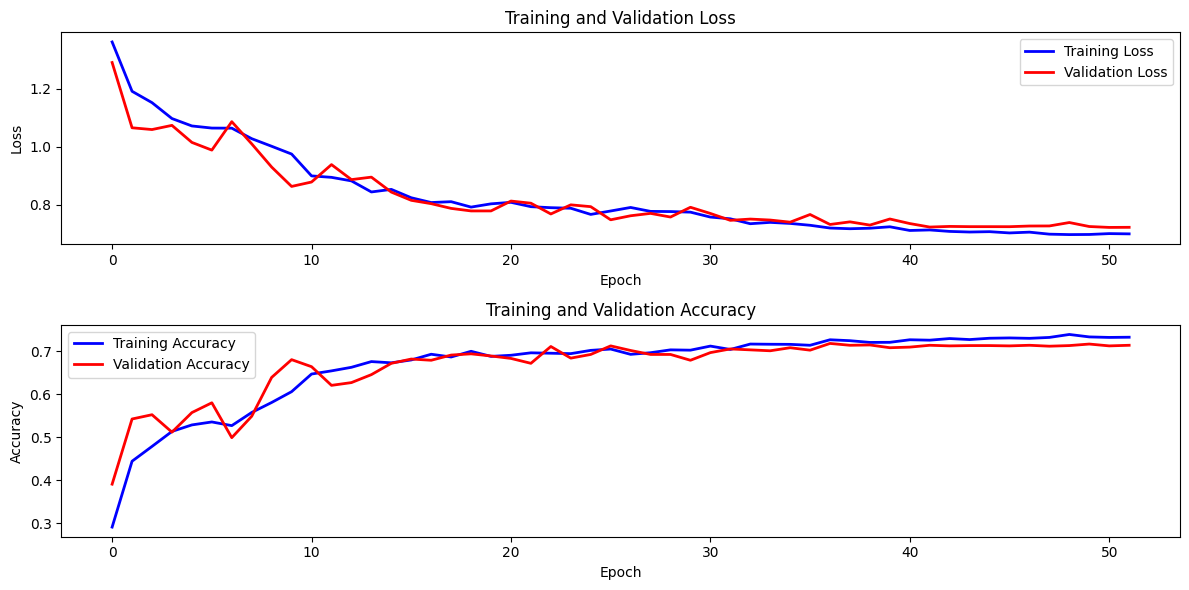

In [15]:
# plot the training curves
plot_training_curves(tl_history)

In [16]:
# obtain prediction on validation data
val_y_pred_rescaled = model.predict(val_data_rescaled)
# obtain predictions on test data
test_y_pred_rescaled = model.predict(test_data_rescaled)

41/41 [==============================] - 0s 12ms/step


C:\Users\Xuxu\AppData\Local\Temp\ipykernel_18184\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', n_classes)


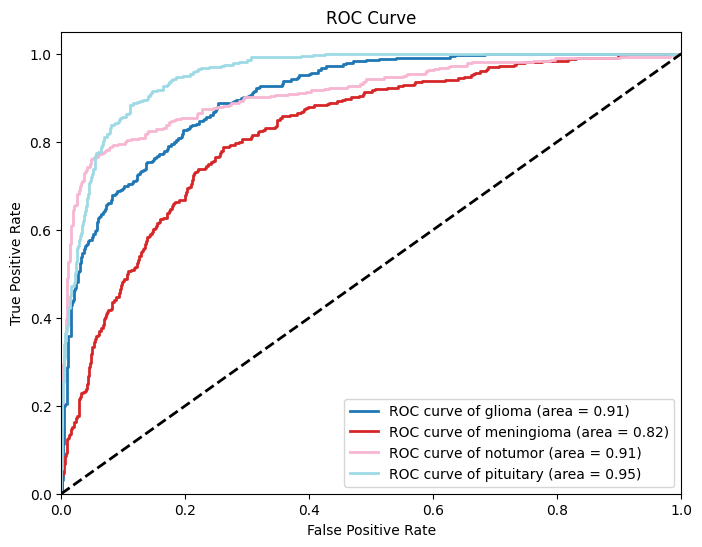

In [17]:
# plot the roc curve of the validation data
plot_roc_curve(val_y_pred_rescaled, val_data_rescaled)

C:\Users\Xuxu\AppData\Local\Temp\ipykernel_18184\2787230574.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', n_classes)


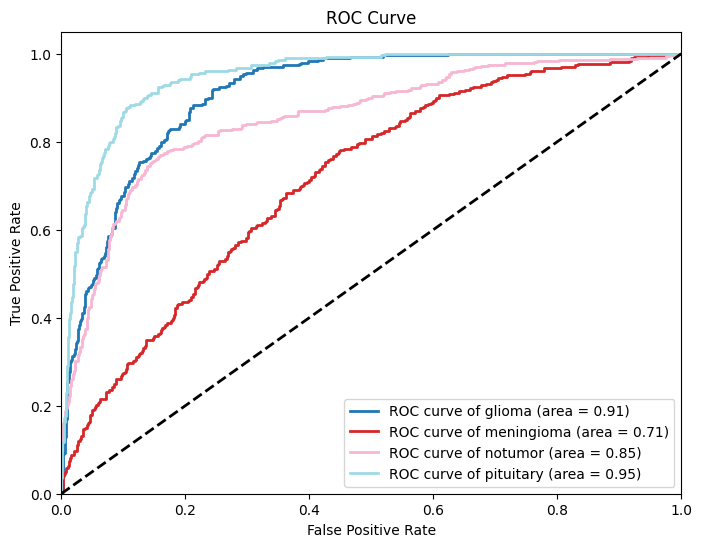

In [18]:
plot_roc_curve(test_y_pred_rescaled, test_data_rescaled)

In [19]:
# get evaluation metric of validation data
get_evaluation_metrics(val_y_pred_rescaled, val_data_rescaled)

f1 score: 0.7180161435239988
Classification Report:
              precision    recall  f1-score   support

      glioma       0.76      0.63      0.69       345
  meningioma       0.55      0.58      0.57       324
     notumor       0.85      0.75      0.80       372
   pituitary       0.72      0.89      0.80       363

    accuracy                           0.72      1404
   macro avg       0.72      0.71      0.71      1404
weighted avg       0.73      0.72      0.72      1404



In [20]:
# get evaluation metric of test data
get_evaluation_metrics(test_y_pred_rescaled, test_data_rescaled)

f1 score: 0.633399429894133
Classification Report:
              precision    recall  f1-score   support

      glioma       0.71      0.55      0.62       300
  meningioma       0.39      0.39      0.39       306
     notumor       0.72      0.72      0.72       405
   pituitary       0.71      0.87      0.78       300

    accuracy                           0.64      1311
   macro avg       0.63      0.63      0.63      1311
weighted avg       0.64      0.64      0.63      1311



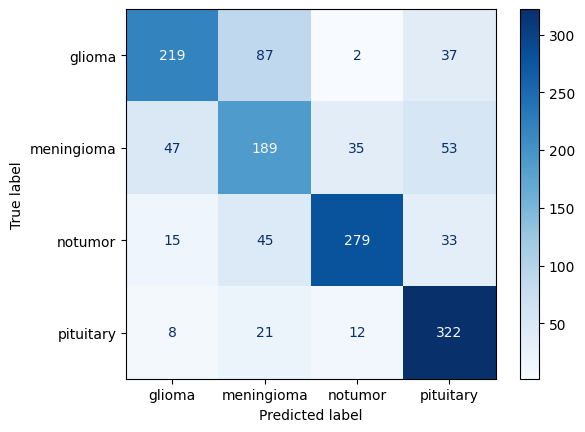

In [21]:
# plot confusion matrix of validation data
plot_confusion_matrix(val_y_pred_rescaled, val_data_rescaled)

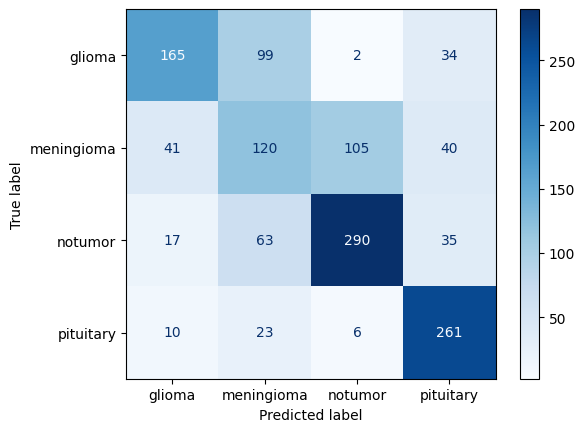

In [22]:
# plot confusion matrix of test data
plot_confusion_matrix(test_y_pred_rescaled, test_data_rescaled)